In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip ./drive/My\ Drive/cifar.zip

In [0]:
import torch
import torchvision
import PIL
import glob
import time

In [0]:
train_imgs = glob.glob('./cifar/train/*.png')
test_imgs = glob.glob('./cifar/test/*.png')
labels = []
with open('./cifar/labels.txt','r') as f:
  labels = f.readlines()
labels = [label.replace('\n','') for label in labels]
num_classes = len(labels)
label_idx_dict = {label:idx for idx, label in enumerate(labels)}

In [0]:
transform_dict = {'train':torchvision.transforms.Compose([
                                                          torchvision.transforms.RandomResizedCrop(32),
                                                          torchvision.transforms.RandomHorizontalFlip(),
                                                          torchvision.transforms.ToTensor(),
                                                          torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                                          ]),
                  'test':torchvision.transforms.Compose([
                                                         torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                  ])
                  }

In [0]:
class CIFAR10Dataset(torch.utils.data.Dataset):
  def __init__(self, img_path, label_idx_dict,transform=None):
    super(CIFAR10Dataset, self).__init__()
    self.img_path = img_path
    self.label_idx_dict = label_idx_dict
    self.transform = transform
    self.img_num = len(self.img_path)

  def __getitem__(self,idx):
    img_p = self.img_path[idx]
    img = PIL.Image.open(img_p)
    label = img_p.split('/')[-1].split('_')[-1].replace('.png','')
    label_idx = self.label_idx_dict[label]

    if self.transform:
      img = self.transform(img)

    return img, label_idx

  def __len__(self):
    return self.img_num

In [0]:
num_epochs = 120
batch_size=512
lr=1e-4

def train(aug=True):
  if aug:
    print('With Augmentation!')
    train_ds = CIFAR10Dataset(train_imgs, label_idx_dict, transform_dict['train'])
  else:
    print('No Augmentation!')
    train_ds = CIFAR10Dataset(train_imgs, label_idx_dict, transform_dict['test'])
  test_ds = CIFAR10Dataset(test_imgs, label_idx_dict, transform=transform_dict['test'])

  train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
  test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False)

  net = torchvision.models.resnet18(pretrained=True)
  net.fc = torch.nn.Linear(512, 10)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(net.parameters(),lr=lr)
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer,num_epochs/3)

  device = 'cuda:0' if torch.cuda.is_available else 'cpu'
  net.to(device)
  torch.backends.cudnn.benchmark=True


  hist = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}
  print('START:')
  for epoch in range(num_epochs):
    net.train()
    epoch_imgs = 0.
    epoch_loss = 0.
    epoch_corrects = 0.

    since=time.time()

    for batch in train_dl:
      imgs, labels = batch
      epoch_imgs += imgs.size(0)
      imgs, labels = imgs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs=net(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()*imgs.size(0)
      epoch_corrects += sum(outputs.argmax(1) == labels)

    l = epoch_loss/epoch_imgs
    a = epoch_corrects/epoch_imgs
    cur_lr =scheduler.optimizer.param_groups[0]['lr']

    hist['loss'].append(l)
    hist['acc'].append(a.item())

    print("Epoch {}: Loss: {:.4f} Acc: {:4f} Time: {:.2f} LR: {}".format(epoch+1, l, a, time.time()-since, cur_lr))

    net.eval()
    val_imgs=0.
    val_loss=0.
    val_corrects=0.
    for batch in test_dl:
      imgs, labels = batch
      val_imgs += imgs.size(0)
      imgs, labels = imgs.to(device), labels.to(device)

      with torch.no_grad():
        outputs = net(imgs)
        loss = criterion(outputs, labels)

      val_loss += loss.item()*imgs.size(0)
      val_corrects += sum(outputs.argmax(1) == labels)

    l = val_loss / val_imgs
    a = val_corrects / val_imgs

    hist['val_loss'].append(l)
    hist['val_acc'].append(a.item())

    print("Val: Loss {:.4f} Acc {:.4f}".format(l, a))


    scheduler.step()

  return hist

In [80]:
aug_hist = train(aug=True)

With Augmentation!
START:
Epoch 1: Loss: 1.4657 Acc: 0.484420 Time: 31.98 LR: 0.0001
Val: Loss 0.9972 Acc 0.6503
Epoch 2: Loss: 1.0648 Acc: 0.628220 Time: 32.29 LR: 0.0001
Val: Loss 0.8421 Acc 0.7137
Epoch 3: Loss: 0.9571 Acc: 0.666880 Time: 32.06 LR: 0.0001
Val: Loss 0.7634 Acc 0.7379
Epoch 4: Loss: 0.8900 Acc: 0.689200 Time: 31.76 LR: 0.0001
Val: Loss 0.7179 Acc 0.7556
Epoch 5: Loss: 0.8495 Acc: 0.702220 Time: 31.99 LR: 0.0001
Val: Loss 0.6776 Acc 0.7679
Epoch 6: Loss: 0.8123 Acc: 0.716260 Time: 31.55 LR: 0.0001
Val: Loss 0.6499 Acc 0.7797
Epoch 7: Loss: 0.7841 Acc: 0.726460 Time: 32.34 LR: 0.0001
Val: Loss 0.6140 Acc 0.7917
Epoch 8: Loss: 0.7583 Acc: 0.736540 Time: 31.79 LR: 0.0001
Val: Loss 0.6280 Acc 0.7872
Epoch 9: Loss: 0.7371 Acc: 0.742980 Time: 30.90 LR: 0.0001
Val: Loss 0.5860 Acc 0.8015
Epoch 10: Loss: 0.7183 Acc: 0.748560 Time: 31.27 LR: 0.0001
Val: Loss 0.6049 Acc 0.7994
Epoch 11: Loss: 0.6999 Acc: 0.755280 Time: 31.63 LR: 0.0001
Val: Loss 0.5697 Acc 0.8074
Epoch 12: Loss:

In [81]:
no_hist = train(aug=False)

No Augmentation!
START:
Epoch 1: Loss: 1.2508 Acc: 0.568920 Time: 27.35 LR: 0.0001
Val: Loss 0.8416 Acc 0.7065
Epoch 2: Loss: 0.6460 Acc: 0.778120 Time: 27.14 LR: 0.0001
Val: Loss 0.7065 Acc 0.7520
Epoch 3: Loss: 0.4230 Acc: 0.857460 Time: 26.98 LR: 0.0001
Val: Loss 0.6798 Acc 0.7722
Epoch 4: Loss: 0.2600 Acc: 0.919020 Time: 27.50 LR: 0.0001
Val: Loss 0.7127 Acc 0.7758
Epoch 5: Loss: 0.1407 Acc: 0.961480 Time: 27.19 LR: 0.0001
Val: Loss 0.7827 Acc 0.7796
Epoch 6: Loss: 0.0655 Acc: 0.986060 Time: 27.40 LR: 0.0001
Val: Loss 0.8348 Acc 0.7792
Epoch 7: Loss: 0.0300 Acc: 0.995740 Time: 27.20 LR: 0.0001
Val: Loss 0.8954 Acc 0.7822
Epoch 8: Loss: 0.0160 Acc: 0.998320 Time: 27.32 LR: 0.0001
Val: Loss 0.9386 Acc 0.7844
Epoch 9: Loss: 0.0093 Acc: 0.999200 Time: 27.25 LR: 0.0001
Val: Loss 0.9697 Acc 0.7843
Epoch 10: Loss: 0.0061 Acc: 0.999720 Time: 27.02 LR: 0.0001
Val: Loss 0.9976 Acc 0.7841
Epoch 11: Loss: 0.0045 Acc: 0.999780 Time: 27.52 LR: 0.0001
Val: Loss 1.0400 Acc 0.7846
Epoch 12: Loss: 0

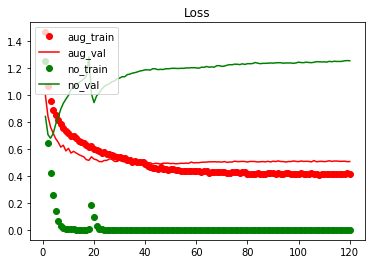

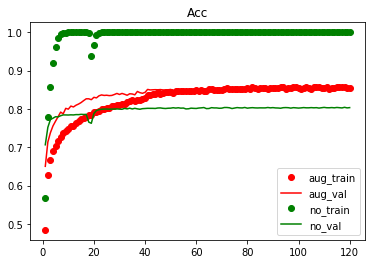

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs =range(1,num_epochs+1)

plt.title('Loss')
plt.plot(epochs, aug_hist['loss'],'ro',label='aug_train')
plt.plot(epochs, aug_hist['val_loss'],'r',label='aug_val')
plt.plot(epochs, no_hist['loss'],'go',label='no_train')
plt.plot(epochs, no_hist['val_loss'],'g',label='no_val')
# plt.ylim((0.0,0.1))
plt.legend()
plt.show()

plt.figure()
plt.title('Acc')
plt.plot(epochs, aug_hist['acc'],'ro',label='aug_train')
plt.plot(epochs, aug_hist['val_acc'],'r',label='aug_val')
plt.plot(epochs, no_hist['acc'],'go',label='no_train')
plt.plot(epochs, no_hist['val_acc'],'g',label='no_val')
# plt.ylim((0.82,0.86))
plt.legend()
plt.show()

## Discussion
Image Augmentation surely makes the model better.

## Experiments
lr=1e-4, batch_size=512
1. lr=1e-3 -> Learning
2. batch_size=5096 -> Slow improvements w.r.t. epochs.